# CSC_52081_EP - Lab 01

### Main Objectives 

Intelligent decision making involves several components. Today we study, in the context of a toy (low-dimensional, synthetic) example: *perception* (observation), *knowledge* (representation), *reasoning* (inference), and *acting* (decision-making). We will _not_ look at (today): learning and sequential decision making. Using probabalistic tools covered in the lecture (Bayesian networks, marginalization, ...), the objective is to design a rational/intelligent agent, i.e., an agent that maximizes its expected reward. 


### Instructions

Work your way through the notebook, and provide code where indicated to complete the tasks. Check Moodle for details on how to submit your work.

### Imports

First, we're going to import `numpy` and some utility functions/classes that we will use. make sure the `environment.py` is in your working directory. 

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

And we'll use the environment defined in the file `environment.py`

In [3]:
# if you are using Google Colab, uncomment the following line (then comment again when you have run it): 
!wget https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/environment.py
from environment import Environment

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.



## The Environment and the Agent

Consider an intelligent agent as a robot tasked with catching rats in a storage room. It is night time, and the room is dark. You have to rely on auditory information only, but luckily the room is a mess with paper and other debris that means there are distinct sounds which are emitted by a rat as it touches different objects (namely, crinkling and rustling sounds). The room is rectangular, divided up into $n$ square tiles.  A rat has just entered the room (current time $t=1$). The agent waits $T$ seconds (i.e., until $t=T$), then makes a decision on if and where to pounce (in order to catch the rat).

Let's instantiate an environment, and render a visualisation of it. 

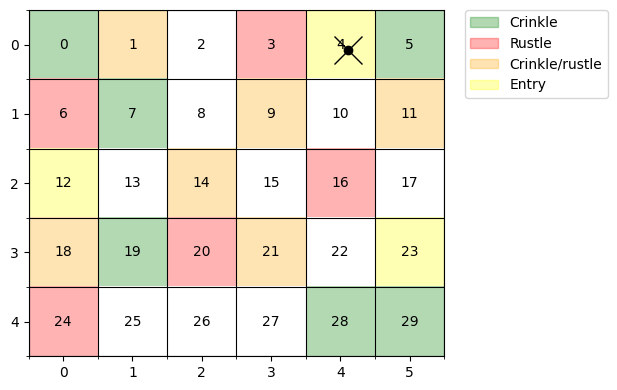

In [4]:
G = np.array([[1,3,0,2,4,1],
              [2,1,0,3,0,3],
              [4,0,3,0,2,0],
              [3,1,2,3,0,4],
              [2,0,0,0,1,1]])

env = Environment(G)
# Plot the environment in state 's_t = 4'
fig, ax = env.render([4], None)
plt.show()

#### Notation

Let $s_t \in \{1,\ldots,n\}$ denote the position (state) of the rat at time step $t$ (one of $n$ grid tiles); starting at some $s_1$ (entry tile). And $\mathbf{x}_t \in \{0,1\}^2$ is the 2-dimensional auditory observation at time $t$ (e.g., $\mathbf{x}_t = [1,0]$ if there is a crinkle but no rustle, etc). The agent accumulates a sequence of **observations** $\mathbf{x}_{1:T} = \mathbf{x}_1,\ldots,\mathbf{x}_T$, with which to make the decision of taking **action** $a$ to pounce (denoting the tile upon which it pounces). The agent obtains **reward** $r(s,a) = 1_{s = a}$, i.e., catching the rat provides reward $1$ and $0$ otherwise. 

As an influence diagram, the problem described can be depicted as follows: 

![pgm](https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/fig/pgm.png)

Your task is to model this problem in Python code. Finally, the goal is to implement an `Agent` which will provide the best action $a$ (according to current knowledge, i.e., given observation sequence $\mathbf{x}_{1:T}$) and associated uncertainty.

**Beware** of the potential confusion here: $s_T$ represents the state of the environment but decision making (choosing action $a$) is based on observation $o = \mathbf{x}_{1:T}$. 

The Environment is fully specified for you, as a Markov process 
$$
    s_{t+1} \sim p(\cdot | s_t)
$$
with observations 
$$
    \mathbf{x}_t \sim p( \cdot | s_t)
$$
You can find this functionality in the `step` function. 

You should be able to see by looking at the code, that the rat moves by exactly $1$ square tile, either horizontally or vertically (i.e., taxicab-distance) per time step $t$, within the bounds of the of the room, starting at one of the entry points (uniformly at random). Insofar as the observation function: a 'crinkle' indicator is generated with probability $\theta_1$ when over certain tiles (green, or orange), and with probability $0$ over other tiles; furthermore, it will invoke a 'rustling' is indicated with probability $\theta_2$ over certain tiles (red, or orange), and $0$ otherwise. On orange tiles, both noises are caused independently of each other.


#### Task 1: Generating trajectories 

Complete the `gen_traj` function to generate a trajectory (of length $T$). You have full acces to the environment, e.g., you can call `env.step(...)`. 

In [5]:
def gen_traj(env, T=5):
    ''' Generate a path with associated observations.

        Paramaters
        ----------

        T : int
            how long is the path

        Returns
        -------

        o : (T,d)-shape array
            sequence of observations
        s : T-length array of states
            sequence of tiles
    '''
    o = []
    s = []

    s.append(env.step()[0])
    o.append(env.step()[1])

    for i in range(T-1):
        temp_s, temp_o = env.step(s[i])
        s.append(temp_s)
        o.append(temp_o)

    return np.array(o), np.array(s)

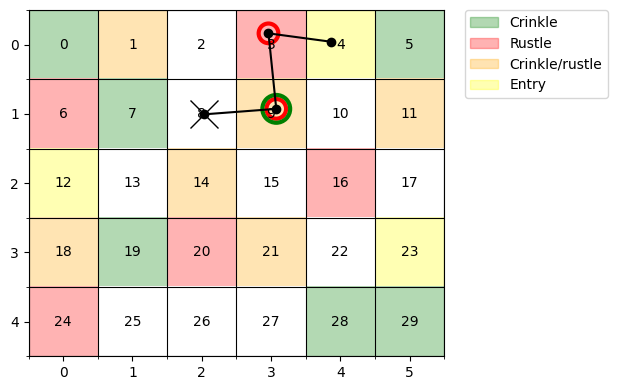

In [6]:
# Generate and view (plot) the trajectory
ooo, sss = gen_traj(env,4)
fig, ax = env.render(sss, ooo)
plt.show()

It is important to realise that although we can have full access to the environment, as well as observations, we do not expect (in the 'real world') to see the true path $s_1,\ldots,s_T$ and hence the challenge in estimating $s_T$. For this we will create an `Agent` class.

In [7]:
class Agent: 

    def __init__(self, env): 
        '''
            env : Environment 
                of the type provided to you
        '''
        self.env = env

    def s_tree(self, T):
        '''
            Provides all possible paths for T iterations.

            Parameters
            ----------

            T : int
                number of iterations

            Returns
            -------

            all_paths : list of lists
                all possible paths of states for the given number of iterations, with size T
        '''

        all_paths = []
        env = self.env

        for t in range(T):
            if t == 0:
                first_s = np.flatnonzero(env.P_1)
                all_paths.extend([[s] for s in first_s])

            elif t == 1:
                current_s = []
                for s in first_s:
                    for j in range(len(np.argwhere(env.P_S[s]))):
                        new = [s]
                        new.append(np.argwhere(env.P_S[s])[j, -1])
                        current_s.append(new)
                last_s = current_s
                all_paths.extend(last_s)

            else:
                current_s = []
                for s in last_s:
                    for j in range(len(np.argwhere(env.P_S[s[-1]]))):
                        new = s.copy()
                        new.append(np.argwhere(env.P_S[s[-1]])[j, -1])
                        current_s.append(new)
                last_s = current_s
                all_paths.extend(last_s)

        all_paths = [s for s in all_paths if len(s) == T]

        return all_paths


    def P_traj(self, ooo, M=-1):
        '''
        Provides full conditional distribution P(SSS | ooo) where SSS and ooo are sequences of length T.
        $$
            P( Y_1,\ldots,Y_T | o_1,\ldots,o_T )
        $$

        Parameters
        ----------

        ooo : array_like(t, d)
            t observations (of d dimensions each)

        M : int
            -1 indicates to use a brute force solution (exact recovery of the distribution) 
            M > 0 indicates to use M Monte Carlo simulations (this parameter is used in Week 2)


        Returns
        -------

        p : dict(str:float)
            such that p[sss] = P(sss | ooo)
            and if sss not in p, it implies P(sss | ooo) = 0

            important: let sss be a string representation of the state sequence, separated by spaces, e.g., 
            the string representation of np.array([1,2,3,4],dtype=int) should be '1 2 3 4'. 
        '''        
        prob = {}
        env = self.env
        
        if M == -1:
            corners = [0, 5, 24, 29]
            sides = [1, 2, 3, 4, 6, 11, 12, 17, 18, 23, 25, 26, 27, 28]

            for i, o in enumerate(ooo):
                o = np.array(o, dtype=int)
                all_paths = self.s_tree(i+1)
                prob_noise = 0

                if i == 0:
                    for s in all_paths:
                        if len(s) == 1:
                            prob[str(np.array(s))[1:-1]] = round(float(env.P_1[s]), 5)
                else:
                    for s in all_paths:
                        current_key = str(np.array(s))[1:-1]
                        path_key = str(np.array(s[:-1]))[1:-1]
                        if s[-2] in corners:
                            prob_a_priori = prob[path_key] / 2
                        elif s[-2] in sides:
                            prob_a_priori = prob[path_key] / 3
                        else:
                            prob_a_priori = prob[path_key] / 4
                        prob[current_key] = round(prob_a_priori * env.P_O[s[-1], 0, o[0]] * env.P_O[s[-1], 1, o[1]], 5)
                        prob_noise += prob[current_key]

            # Filter the paths and probabilities added in the last loop
            p = {k: v/prob_noise for k, v in prob.items() if len(k.split()) == len(all_paths[0])}
                            
        return p

        
    def P_S(self, ooo, t=-1, M=-1): 
        '''
        Provide P(s_t | ooo) given observations o from 1,...,T.  

        $$
            P(S_t | o_1,...,o_T ).
        $$
        
        The probability (distribution) of the t-th state, given the observed evidence 'o'.

        Parameters
        ----------

        ooo : array_like(t, d)
            t observations (of d dimensions each)

        t : int
            the state being queried, e.g., 3, or -1 for final state (corresponding to o[-1])

        Returns
        -------

        P : array_like(float,ndim=1) 
            such that P[s] = P(S_t = s | o_1,...,o_t)
        '''

        P = np.zeros(self.env.n_states)

        if t != -1:
            ooo = ooo[:t+1]

        p = self.P_traj(ooo)
        prob_paths = [path for path in p.keys() if p[path] != 0]

        for path in prob_paths:
            P[int(path.split()[-1])] += p[path]
        
        return P

    def Q(self, o): 
        '''
            Provide Q(o,a) for all a i.e., the value for any given a under observation o. 

            Parameters
            ----------

            o : array_like(int,ndim=2)
                t observations (of 2 bits each)

            Returns
            -------

            Q : array_like(float,ndim=n_actions)
                such that Q[a] is the value (expected reward) of action a.

        '''
        Q = []
        P_S = self.P_S(o)
        max_probability = max(P_S)
        
        for prob in P_S:
            if prob == max_probability:
                Q.append(1)
            else:
                Q.append(0)

        return np.array(Q)

    def act(self, obs): 
        '''
        Decide on the best action to take, under the provided observation. 

        Parameters
        ----------

        obs : array_like(int,ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        a : int
            the chosen action a
        '''

        P_S = self.P_S(obs)
        max_probability = max(P_S)
        most_probable_tile = np.flatnonzero(P_S == max_probability)
        a = np.random.choice(most_probable_tile)

        return a

In [8]:
# Let's instantiate our agent
agent = Agent(env)

The Agent is responsible for receiving observation $o = \mathbf{x}_{1:T}$ and producing prediction $a$, i.e., it implements $a = \pi(o)$, i.e., its policy or `act` function as it is called here below. But let's implement the functionality step by step. 

#### Task 2: Complete the `P_traj` function above, which specifies  
$$
    P(S_{1:T} | \mathbf{x}_{1:T})
$$
(returns a distribution, one number associated to each *possible* trajectory $s_1,\ldots,s_T$).


Implementation hint: For this, and remaining tasks. It may be useful to implement for the simple case of a single state observation (single time step) first. 

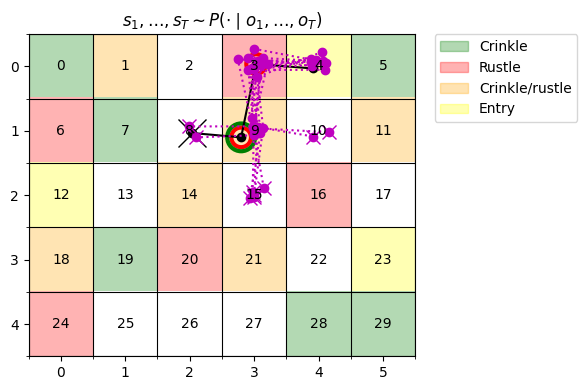

In [9]:
# Call your function
P_joint = agent.P_traj(ooo)

# Check should sum to 1 (or close enough)
probs = list(P_joint.values())
assert abs(sum(probs) - 1) <= 0.05

# Extract possible paths
paths = [np.fromstring(k, sep=' ') for k in P_joint.keys()] 
# print(paths)

# Take some samples
sample_indices = np.random.choice(len(probs), size=10, p=probs)
trajs = [paths[i].astype(int) for i in sample_indices]

fig, ax = env.render(sss, ooo, paths=trajs, title=r"$s_1,\ldots,s_T \sim P(\cdot \mid o_1,\ldots,o_T)$")
plt.show()

#### Task 3: complete the `P_S(o,t)` function, which implements 
$$
    P(S_{t} | \mathbf{x}_{1:T})
$$
(returns a distribution, one number for each possible $s_t$).

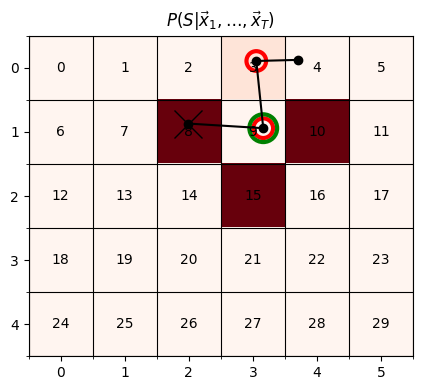

Most probable tile(s): [8, 10, 15], probability: 32.26%


In [10]:
# Visualise P(S_t)
s = sss#[-1]
o = ooo#[-1]

P_S = agent.P_S(o)

fig, ax = env.render(sss, ooo, dgrid=P_S, title=r"$P(S | \vec{x}_1,\ldots,\vec{x}_T)$")
plt.show()

prob_max_tile = max(P_S)
most_prob_tile = [s for s, prob in enumerate(P_S) if prob == prob_max_tile]
print(f"Most probable tile(s): {most_prob_tile}, probability: {prob_max_tile*100:.2f}%")

#### Task 4: complete the value function `Q`, which implements 
$$
    Q(S, \mathbf{x}_{1:T}) = V(S)
$$
(i.e., one number for each state). This is based on $P(S_t)$ but takes into account the reward. 

In the following you can visualise.

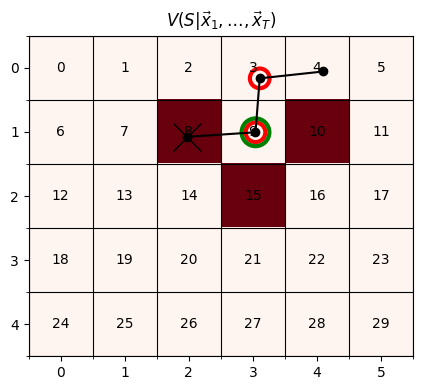

In [11]:
# Visualise the value function
Q_A = agent.Q(o)
fig, ax = env.render(sss, ooo, dgrid=Q_A, title=r"$V(S | \vec{x}_1,\ldots,\vec{x}_T)$")
plt.show()

#### Task 5: Taking an Action

Complete the `act` function, which implements 
$$
    a = \pi(s)
$$
This should be straightforward from the previous; acting to maximize value. 

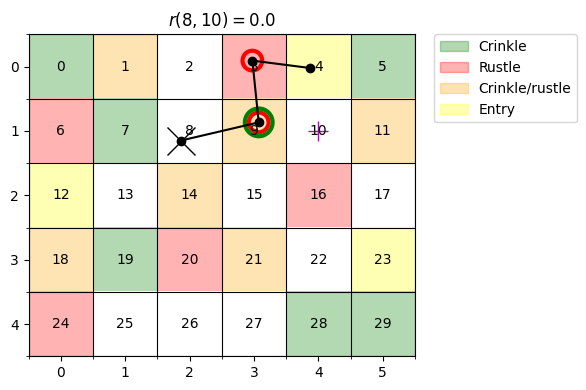

In [12]:
s_T = sss[-1]
a = agent.act(ooo)
r = env.rwd(s_T,a)
fig, ax = env.render(sss, ooo, a_star=a, title="$r(%d,%d) = %2.1f$" % (s_T,a,r))

#### Recap 

Your agent has observed evidence $\mathbf{x}_1,\ldots,\mathbf{x}_T$, and queried the model, according to your beliefs (environment dynamics). Time to make a decision. Which action to take? The answer: 
$$
    a_* = \text{argmax}_a \mathbb{E}_{S_T \sim P(S_T | \mathbf{x}_{1:T})}[ r(S_T, a) ]
$$

Note your uncertainty about the final state $S_T$. 

In this scenario the action does not affect future observations (because $s_T$ is the final observation), thus you are essentially making an estimate:
$$
    a = \hat s_{T} = \pi(\mathbf{x}_{1:T})
$$

We have referred to 'value' and `Q` inline with reinforcement learning terminology. 

Did you get the maximum reward? Remember, an agent is not expected to obtain maximum reward, it is expected to obtain (close to) maximum *expected* reward, under the uncertainty implied by the environment. The following code block will help ascertain the 'success rate' of your agent.

#### Evaluating the Agent

If you have implemented all the above tasks, then we should be able to evaluate the performance of your agent over a number of simulations. 

In [13]:
# Check average performace over n trials
n = 100
r_avg = 0
for i in range(n): 
    ooo, sss = gen_traj(env,5)
    a = agent.act(ooo)
    r_avg += env.rwd(sss[-1],a) / n

print(f"Reward (prediction of agent) average: {r_avg*100:.2f}%")

Reward (prediction of agent) average: 65.00%


## Conclusion (so what?)

This was just a toy example, but consider the fundamental concepts here (we will be using them again); we designed an intelligent decision-making agent involving *perception* (observation), *knowledge* (representation), *reasoning* (inference), and *acting* (decision-making). There are two limitations here: the toy nature of the environment (maybe your solution does not scale up to large $d$ or large $T$) and the requirement for a hand-coded environment. Next week we will look at efficient inference, and learning (including, representation learning) which allows to overcome these limitations; toward not only an autonomous agent, but a capable and scalable autonomous agent. 